In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage
import matplotlib.colors as colors
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'
np.warnings.filterwarnings('ignore')


Xdict = {}
Pdict = {}

cmap = plt.get_cmap('jet')
half_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1.0),
        cmap(np.linspace(0.5, 1.0, 100)))

In [3]:
'''
k-space representation of infinitely thin pressure source 
of finite length (1 / 2 F). So ranges from [-1/F, 1/F]
'''
def phi_finite(kx, ky, F2, l):
    k = np.sqrt(kx * kx + ky * ky)
    pressure = 2. * F2 * np.sin(ky / (2 * F2)) / ky
    pressure[ky == 0] = 1
    return k * pressure / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.01, kmax=128, d=0.125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_finite(k[:, None], k[None, :], \
                             np.power(F, 2.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [4]:
phase = -1.7

def calc_T_value(kmax):
    '''
    Calculate the cutoff T value given a cutoff kmax value
    Note that the kmax cutoff value creates a square in k-space
    with side length 2*kmax
    '''
    km2 = kmax * kmax
    if km2 < 2:
        return km2
    return (1. + np.sqrt(1 + 4 * km2)) / 2.    
    
def draw_wake_plot(ax, x, phi, bound=None, scale=False, magnitude=False):
    r = x[-1]
        
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
        avg = np.average(phi)
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        if magnitude:
            img = ax.imshow(np.abs(toshow), extent=[-r, r, -r, r], \
                             interpolation='gaussian', cmap='Greys',
                             vmin=0, vmax=1)
        else:
            img = ax.imshow(toshow, extent=[-r, r, -r, r], \
                             interpolation='gaussian',
                             vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        if magnitude:
            img = ax.imshow(np.abs(toshow), extent=[-r, r, -r, r], \
                             interpolation='gaussian', cmap='Greys')
        else:
            img = ax.imshow(toshow, extent=[-r, r, -r, r], \
                             interpolation='gaussian')
    return img

def draw_kelvin_angle_long(ax, x, F, color='blue'):
    slope = -1. / np.sqrt(8)
    y = slope * (x + 0.5 / (F * F))
    ax.plot(x, y, color=color, linestyle=':', linewidth=2)

def fplus(x, y):
    x2 = np.power(x, 2.0)
    y2x2 = np.power(y, 2.0) / x2
    num = -x2 * np.power(1. + 4. * y2x2 + np.sqrt(1. - 8. * y2x2), 1.5)
    den = 4. * np.sqrt(2.) * y * (1. + np.sqrt(1. - 8. * y2x2))
    return num / den

def fminus(x, y):
    x2 = np.power(x, 2.0)
    y2x2 = np.power(y, 2.0) / x2
    num = -x2 * np.power(1. + 4. * y2x2 - np.sqrt(1. - 8. * y2x2), 1.5)
    den = 4. * np.sqrt(2.) * y * (1. - np.sqrt(1. - 8. * y2x2))
    return num / den

def phase_contour_diff_color(ax, x, y, a, f, rng, extent, colors=['orange', 'red'], kmax=None):
    fo = (2 * rng + 1) * np.pi
    kns = np.power(fo, 2) * np.power(f, 4)
    #print(kns)
    if kmax is not None:
        fo = fo[kns < kmax]
        kns = kns[kns < kmax]
    mask = kns < 1.5

    ax.contour(x, y, fplus(x + a/2., y) - fplus(x - a/2., y), fo[mask],
               colors=colors[0], linestyles=':', extent=extent, linewidths=2)
    ax.contour(x, y, fminus(x + a/2., y) - fminus(x - a/2., y), fo[mask],
               colors=colors[0], linestyles=':', extent=extent, linewidths=2)
    ax.contour(x, y, fplus(x + a/2., y) - fplus(x - a/2., y), fo[~mask],
                colors=colors[1], linestyles=':', extent=extent, linewidths=1.5)
    ax.contour(x, y, fminus(x + a/2., y) - fminus(x - a/2., y), fo[~mask],
               colors=colors[1], linestyles=':', extent=extent, linewidths=1.5)
    

In [6]:
bigFs = [1.7, 1.5, 1.3, 1.0956]
lrgFs = [1.0, 0.9, 0.8, 0.75]
smlFs = [0.580, 0.564190, 0.500, 0.398943]
lowFs = [0.36, 0.326, 0.3, 0.282, 0.27, 0.252, 0.24, 0.230, 0.22, 0.2135, 0.205, 0.199]

kmax = 64 #For testing
#kmax = 128 #For final images
delta = 1. / 16.

def generate_wake_patterns(xdict, pdict, fvals, kmax, delta):
    for f in fvals:
        x, p = calculate_wake(f, kmax=kmax, d=delta)
        xdict[f] = np.real(x)
        pdict[f] = np.real(p)
        print('F = %f done' % f)

In [22]:
generate_wake_patterns(Xdict, Pdict, bigFs, kmax, delta)

F = 1.700000 done
F = 1.500000 done
F = 1.300000 done
F = 1.095600 done


In [7]:
generate_wake_patterns(Xdict, Pdict, lrgFs, kmax, delta)
generate_wake_patterns(Xdict, Pdict, smlFs, kmax, delta)

F = 1.000000 done
F = 0.900000 done
F = 0.800000 done
F = 0.750000 done
F = 0.580000 done
F = 0.564190 done
F = 0.500000 done
F = 0.398943 done


In [7]:
generate_wake_patterns(Xdict, Pdict, lowFs, kmax, delta)

F = 0.360000 done
F = 0.326000 done
F = 0.300000 done
F = 0.282000 done
F = 0.270000 done
F = 0.252000 done
F = 0.240000 done
F = 0.230000 done
F = 0.220000 done
F = 0.213500 done
F = 0.205000 done
F = 0.199000 done


In [29]:
def create_large_figure(rows, bound=None, scale=False, 
                        showmag=False, phase=None, 
                        xbounds=None, xticks=None, 
                        ybounds=None, yticks=None):
    npy, npx = rows.shape
    fig, axes = plt.subplots(nrows=npy, ncols=npx, sharex='col', sharey='row', figsize=(11.5, 3*npy))
    label = 'a'
    mag = False
    
    for j in range(npy):
        for i in range(npx):
            fr = rows[j, i]
            ax1 = axes[j][i]
            ax1.set_adjustable('box-forced')
            if xbounds is not None:
                ax1.set_xlim(xbounds)
            if ybounds is not None:
                ax1.set_ylim(ybounds)
            if xticks is not None:
                ax1.set_xticks(xticks)
            if yticks is not None:
                ax1.set_yticks(yticks)
            
            ax1.text(0.97, 0.97, r'F = %.3f' % fr, transform=ax1.transAxes, 
                        horizontalalignment='right', 
                        verticalalignment='top')
            lbl = label
            if showmag:
                mag = False
                if j % 2 == 1:
                    lbl = chr(ord(label) - (npx-i)) + '\''
                    mag = True
            ax1.text(0.97, 0.03, lbl, transform=ax1.transAxes,
                        horizontalalignment='right',
                        verticalalignment='bottom')

            #Plot main image
            bnd = bound[j, i] if isinstance(bound, np.ndarray) else bound
            img1 = draw_wake_plot(ax1, Xdict[fr], Pdict[fr], 
                                  scale=scale, bound=bnd, magnitude=mag)

            a = 1. / (fr * fr)
            xm = Xdict[fr][Xdict[fr] < -0.5 * a]
            ym = Xdict[fr][Xdict[fr] > 0]

            ax1.plot(np.zeros(2), np.array([-0.5 * a, 0.5 * a]), color='black', linewidth=2)
            draw_kelvin_angle_long(ax1, xm, fr)    
            if not phase is None:
                x, y = np.meshgrid(xm, ym)
                phase_contour_diff_color(ax1, x, y, a, fr, phase, extent=[xm[0], xm[-1], ym[0], ym[-1]], kmax=kmax)

            if j == npy-1:
                ax1.set_xlabel('X')
            if i == 0:
                ax1.set_ylabel('Y')

            if not showmag or j %2 == 0:
                label = chr(ord(label) + 1)
    #Add colorbars
    fig.subplots_adjust(wspace=0.05, hspace=0.07)
    ticksmag = [0, 0.5, 1]
    ticksreg = [-1, -0.5, 0, 0.5, 1]
    for j in range(npy):
        bb = axes[j][i].get_position().bounds
        cbar_ax = fig.add_axes([bb[0]+bb[2]+0.01, bb[1], 0.01, bb[3]])
        img = [obj for obj in axes[j][-1].get_children() if isinstance(obj, AxesImage)][0]
        fig.colorbar(img, cax=cbar_ax, 
                     ticks=ticksreg if (j % 2 == 0 or not showmag) else ticksmag)

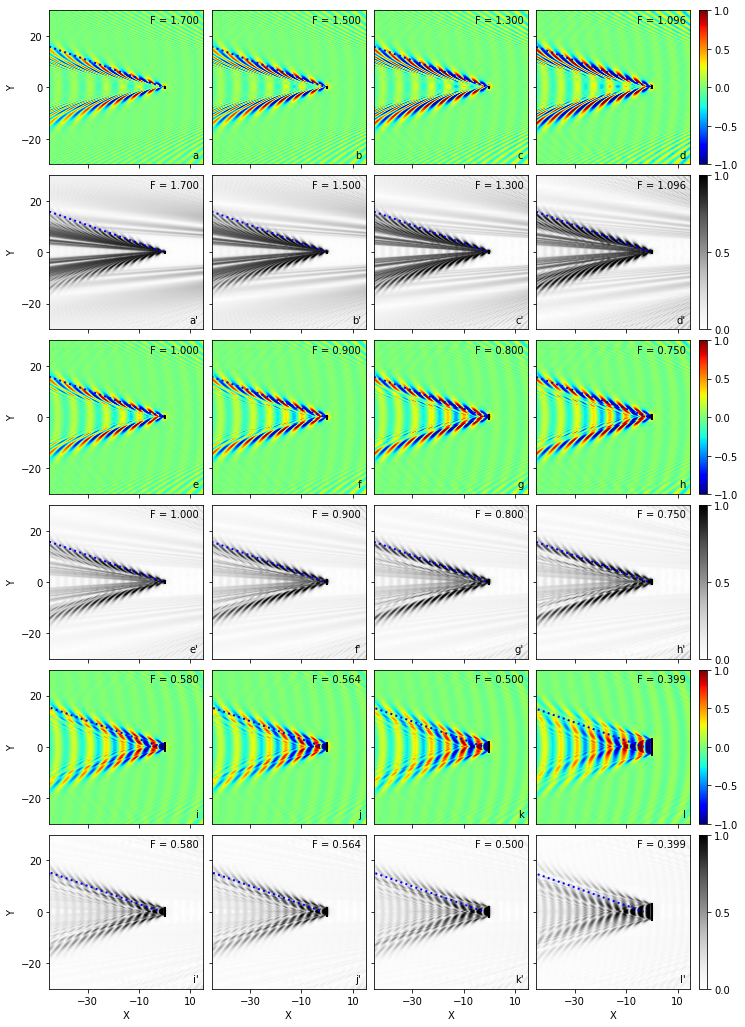

In [32]:
rows = np.array([bigFs, bigFs, lrgFs, lrgFs, smlFs, smlFs])
bounds = np.ones([rows.shape[0], rows.shape[1]])
bounds[:2, :] = 3
bounds[2:4, :] = 5
bounds[4:, :] = 7
create_large_figure(rows, bound=bounds, scale=True, showmag=True, 
                    xbounds=[-45, 15], xticks=[-30, -10, 10], 
                    ybounds=[-30, 30], yticks=[-20, 0, 20])
plt.show()